# Audio feature extraction

Feature extraction in speech, audio, or voice processing is a critical step in converting raw audio signals into meaningful information for analysis and machine learning applications. The process involves identifying and extracting key characteristics from the audio signal that can be used for various tasks, such as speech recognition, speaker identification, and emotion detection.

In this lab, we will explore various types of audio features and practice extracting these features using `torchaudio` and `librosa`.

`torchaudio` implements feature extractions commonly used in the audio domain. They are available in `torchaudio.functional` and `torchaudio.transforms`.

To install required packages in this lab, run:
```bash
pip install requirements.txt
```

## Import library

In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.4.0+cu121
2.4.0+cu121


## Load audio file

In [3]:
import IPython.display as ipd

# Load audio file
audio_path = './test.wav'
data, sampling_rate = torchaudio.load(audio_path)

# Play audio
ipd.Audio(data, rate=sampling_rate)

## Waveform

Waveform is a fundamental concept in audio processing that represents how sound waves vary over time. At its core, a waveform is a visual depiction of the amplitude of an audio signal as it fluctuates, creating the sound we hear. These variations are typically displayed on a time axis, showing how the signal's strength changes moment by moment.

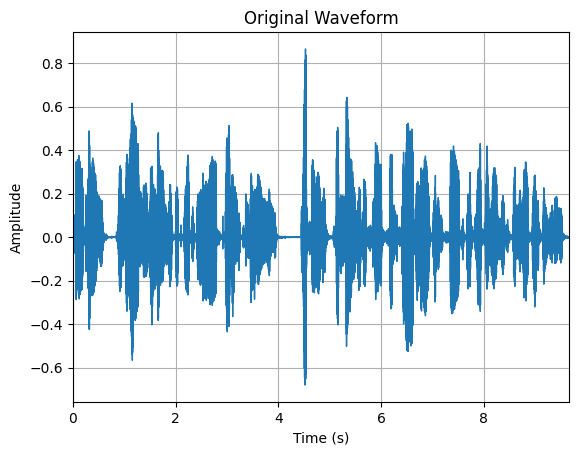

In [16]:
import matplotlib.pyplot as plt
import torch

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    """
    Plots the waveform of an audio signal.

    Parameters:
    waveform (Tensor): The audio waveform tensor with shape (num_channels, num_frames).
    sr (int): The sampling rate of the audio signal.
    title (str): The title of the plot (default is "Waveform").
    """
    # Convert waveform to numpy array
    waveform = waveform.numpy()

    # Determine the number of channels and frames in the waveform
    num_channels, num_frames = waveform.shape

    # Create time axis based on the number of frames and sampling rate
    time_axis = torch.arange(0, num_frames) / sr

    # Create a new figure and axes
    _, ax = plt.subplots()

    # Plot the waveform for the first channel (if multi-channel)
    ax.plot(time_axis, waveform[0], linewidth=1)
    
    # Add grid, set x-axis limits, and add title
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

    # Optionally, set labels for x and y axes
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')

    # Show the plot
    plt.show()


plot_waveform(data, sampling_rate, title="Original Waveform")


## Spectrogram

A spectrogram is a powerful tool in audio processing that provides a detailed visual representation of how the frequency content of a sound evolves over time. Unlike a waveform, which shows amplitude variations, a spectrogram displays frequency on the vertical axis, time on the horizontal axis, and color or intensity to represent the amplitude or power of each frequency component.

Spectrograms are especially useful in deep learning for speech, speech analysis, and acoustic research, where a deeper understanding of the frequency domain is crucial.

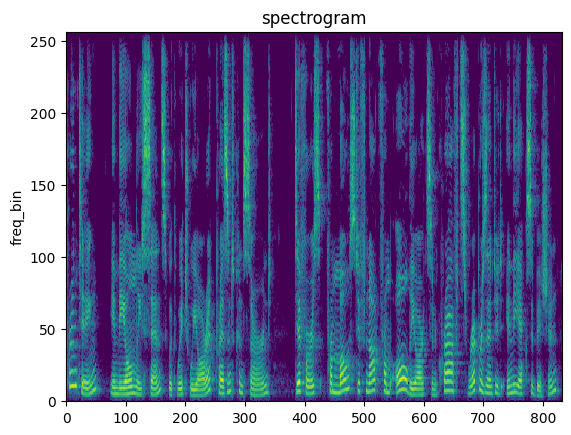

In [13]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(data)

plot_spectrogram(spec[0], title="spectrogram")

In [5]:
def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

//TODO: more about n_fft

## GriffinLim

To recover a waveform from a spectrogram, you can use `torchaudio.transforms.GriffinLim`

The same set of parameters used for spectrogram must be used.

In [14]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(data)
reconstructed_waveform = griffin_lim(spec)

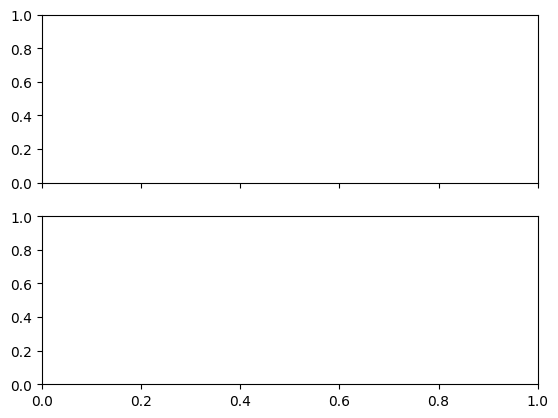

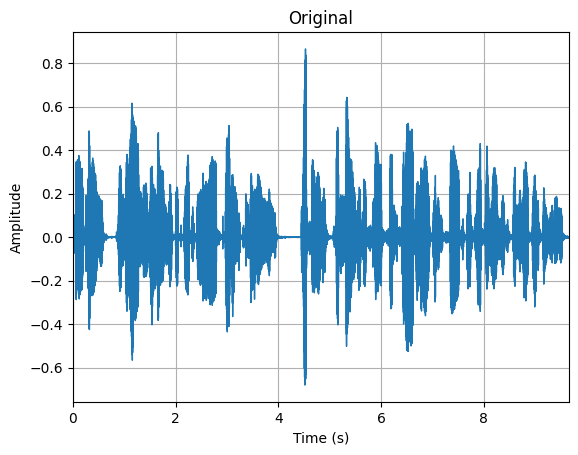

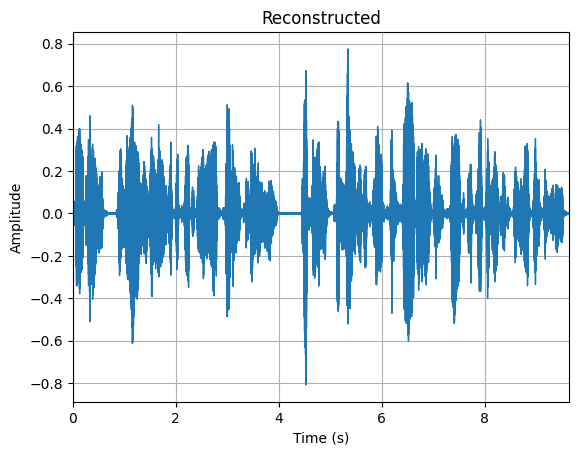

In [17]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(data, sampling_rate, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, sampling_rate, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=sampling_rate)

## Mel Filter Bank
torchaudio.functional.melscale_fbanks() generates the filter bank for converting frequency bins to mel-scale bins.

Since this function does not require input audio/features, there is no equivalent transform in torchaudio.transforms().

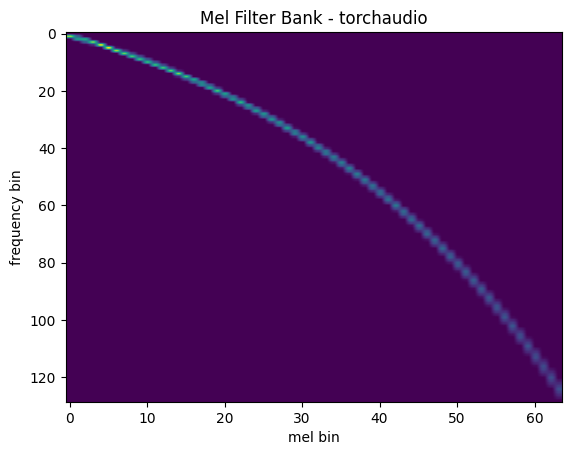

In [17]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

# MelSpectrogram

The Mel spectrogram is an advanced variation of the traditional spectrogram, tailored to better align with human auditory perception. It transforms audio signals into a time-frequency representation where the frequency axis is scaled according to the Mel scale, which mimics the way humans perceive pitch.

Generating a mel-scale spectrogram involves generating a spectrogram and performing mel-scale conversion. In torchaudio, torchaudio.transforms.MelSpectrogram() provides this functionality.

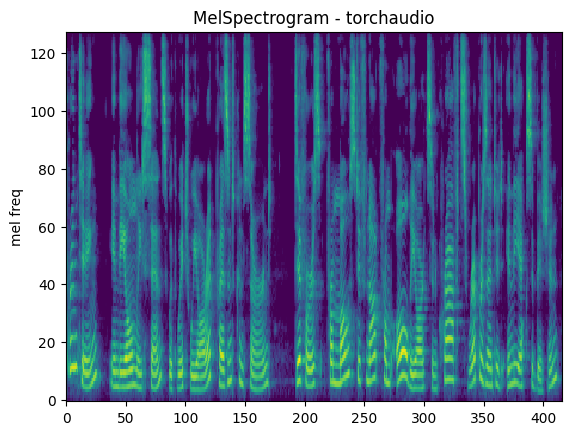

In [18]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(data)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

# MFCC

MFCCs are a set of coefficients that collectively represent the short-term power spectrum of a sound signal. They are derived from the Mel spectrogram and are designed to capture the characteristics of the human auditory system, making them particularly useful for tasks like speech recognition.

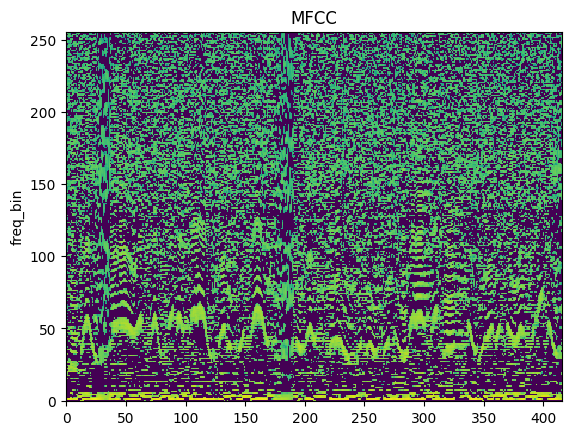

In [19]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(data)
plot_spectrogram(mfcc[0], title="MFCC")

# LFCC

LFCCs are a set of coefficients that represent the short-term power spectrum of a sound signal, but unlike MFCCs, which use the Mel scale, LFCCs use a linear frequency scale. This means that the frequency axis is not warped to match human auditory perception but is instead represented in a more straightforward linear manner.

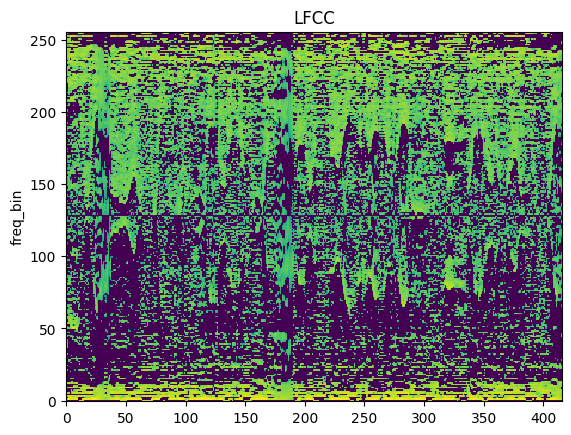

In [20]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(data)
plot_spectrogram(lfcc[0], title="LFCC")

# Pitch

Pitch is a fundamental aspect of sound that refers to the perceived frequency of a sound, which determines how high or low it sounds to the human ear. In audio processing and music, pitch plays a crucial role in defining musical notes, tuning, and harmonics.

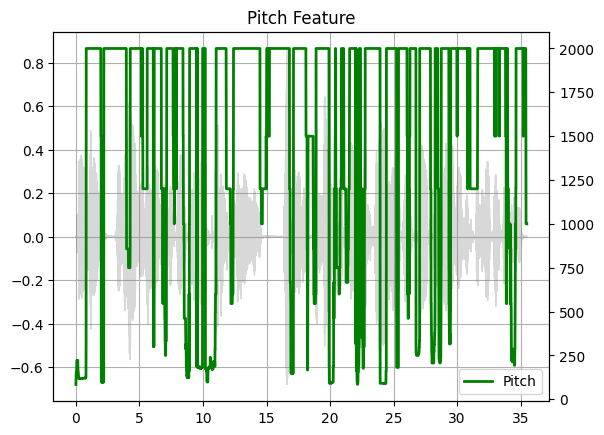

In [21]:
pitch = F.detect_pitch_frequency(data, sample_rate)
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(data, sample_rate, pitch)